In [43]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from mixture_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
num_features =  6
x_training = np.array([-0.9, -0.8, 0.05, 0.1, 0.15, 0.9, 0.95])
var = 0.1
X_poly, y, x_interval, y_interval, y_training = create_data(
    x_training, var, degree=num_features-1
)
X_pred_poly = create_test_data(x_interval, degree=num_features-1)
theta = fit_linear_regression(X_poly, y)
y_pred = X_pred_poly @ theta
nfs = get_pnml_normalization_factor(X_pred_poly, X_poly)

In [45]:
combs = create_subspaces_all_permutations(num_features)
U, s, _ = np.linalg.svd(X_poly.T @ X_poly, hermitian=True)
Z = np.zeros((len(combs), len(y_interval), len(x_interval)))
subspace_predictions = []

weighted_aggregation = True
for n, subspace in enumerate(combs):
    y_pred_svd, x_inv = calc_subspace_prediction(X_pred_poly, X_poly, y, U, s, subspace)
    nf = get_pnml_normalization_factor(X_pred_poly, X_poly, x_inv=x_inv)

    for i, x in enumerate(x_interval):
        mu = y_pred_svd[i].squeeze()
        var = 0.1 * nfs[i].squeeze() ** 2
        predictions = calc_gaussian_probabilities(mu, var, y_interval)
        Z[n, :, i] = 1/len(subspace) * predictions if weighted_aggregation else predictions

    subspace_predictions.append(y_pred_svd)

Z_avg = np.mean(Z, axis=0)

KeyboardInterrupt: 

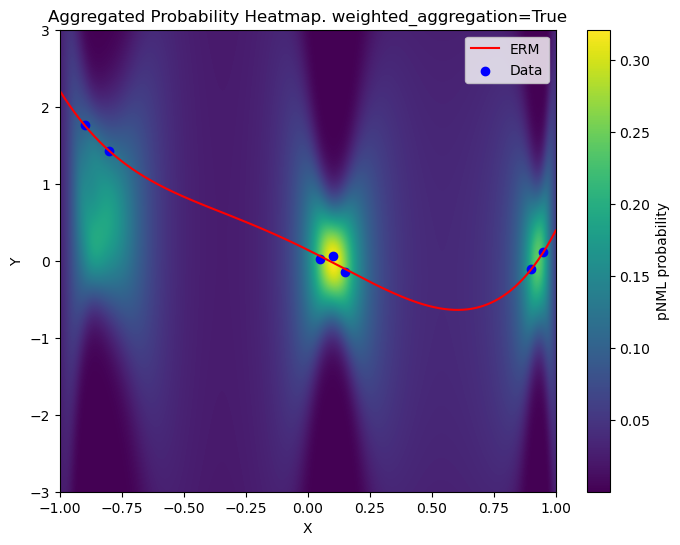

In [ ]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.plot(x_interval, y_pred.squeeze(), color="red", label="ERM")
plt.scatter(x_training, y_training, color="blue", label="Data")
plt.imshow(
    Z_avg,
    extent=[x_interval[0], x_interval[-1], y_interval[0], y_interval[-1]],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
plt.colorbar(label="pNML probability")

plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"Aggregated Probability Heatmap. {weighted_aggregation=}")
plt.legend()
plt.show()

In [ ]:
combs

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 3, 4),
 (0, 3, 5),
 (0, 4, 5),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (1, 3, 4),
 (1, 3, 5),
 (1, 4, 5),
 (2, 3, 4),
 (2, 3, 5),
 (2, 4, 5),
 (3, 4, 5),
 (0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 2, 5),
 (0, 1, 3, 4),
 (0, 1, 3, 5),
 (0, 1, 4, 5),
 (0, 2, 3, 4),
 (0, 2, 3, 5),
 (0, 2, 4, 5),
 (0, 3, 4, 5),
 (1, 2, 3, 4),
 (1, 2, 3, 5),
 (1, 2, 4, 5),
 (1, 3, 4, 5),
 (2, 3, 4, 5),
 (0, 1, 2, 3, 4),
 (0, 1, 2, 3, 5),
 (0, 1, 2, 4, 5),
 (0, 1, 3, 4, 5),
 (0, 2, 3, 4, 5),
 (1, 2, 3, 4, 5),
 (0, 1, 2, 3, 4, 5)]

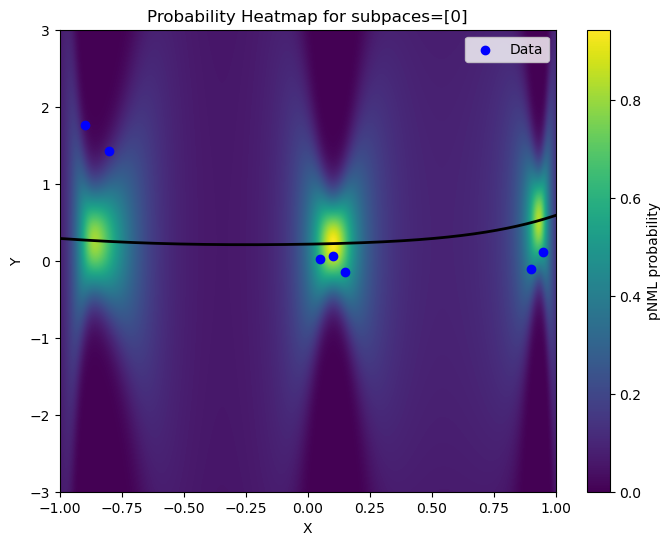

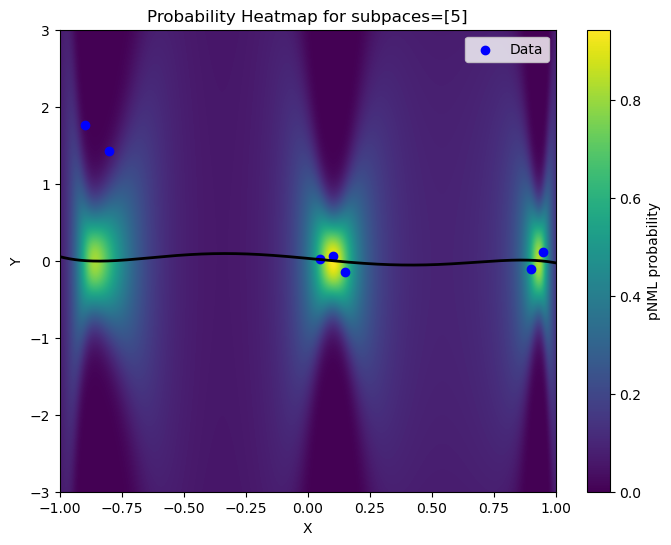

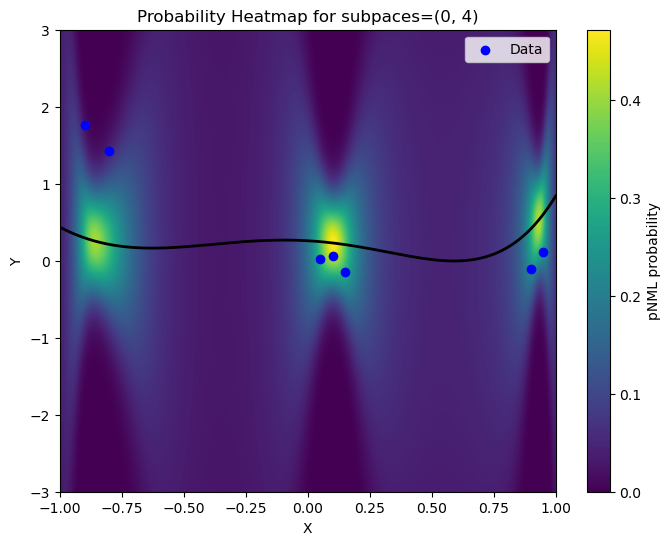

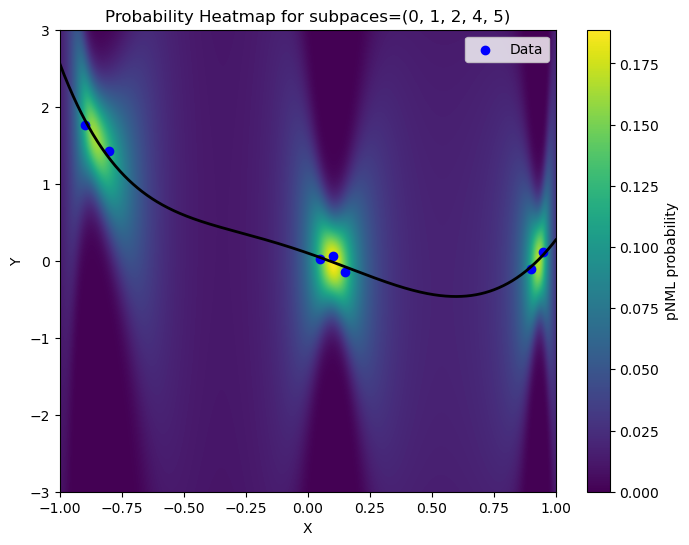

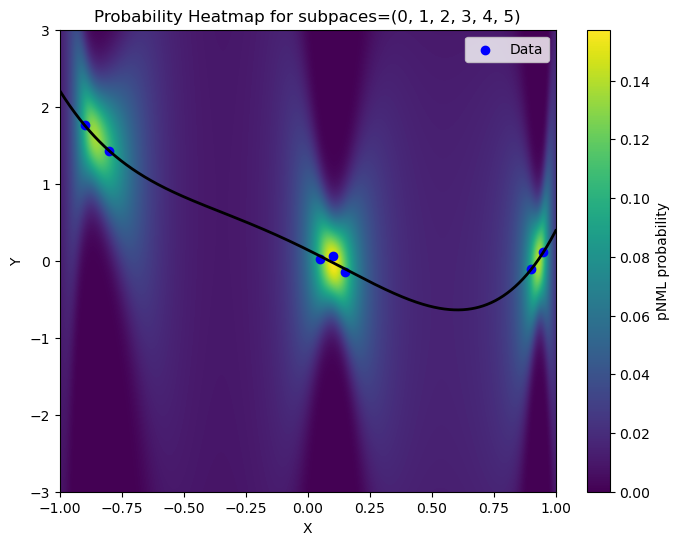

In [ ]:
indices = [0, 5, 9, -5, -1]

for idx in indices:
    plt.figure(figsize=(8, 6))
    plt.imshow(
        Z[idx],
        extent=[x_interval[0], x_interval[-1], y_interval[0], y_interval[-1]],
        origin="lower",
        aspect="auto",
        cmap="viridis",
    )
    plt.plot(x_interval, subspace_predictions[idx], "k-", linewidth=2)

    plt.colorbar(label="pNML probability")
    plt.scatter(x_training, y_training, color="blue", label="Data")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Probability Heatmap for subpaces={combs[idx]}")
    plt.legend()
    plt.show()

# Avg over the same pred

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)


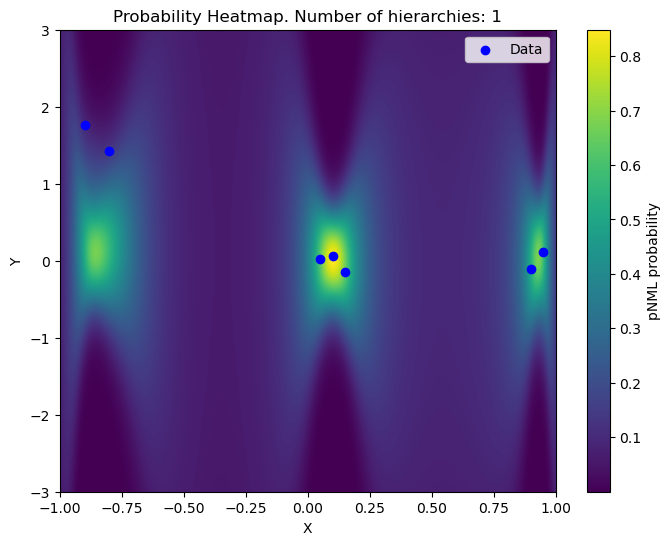

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(2, 5)
(3, 4)
(3, 5)
(4, 5)


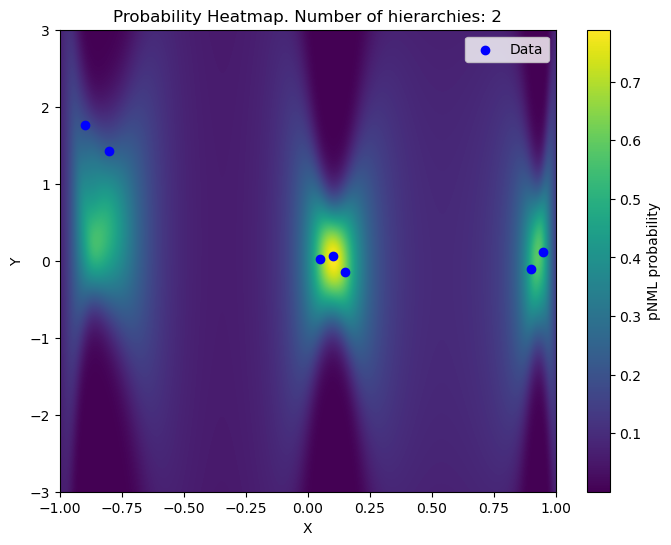

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 3, 4)
(0, 3, 5)
(0, 4, 5)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 3, 4)
(1, 3, 5)
(1, 4, 5)
(2, 3, 4)
(2, 3, 5)
(2, 4, 5)
(3, 4, 5)


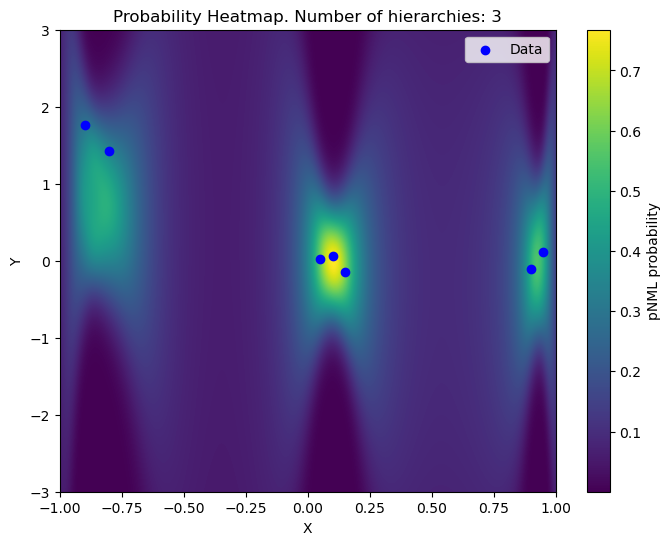

(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 2, 5)
(0, 1, 3, 4)
(0, 1, 3, 5)
(0, 1, 4, 5)
(0, 2, 3, 4)
(0, 2, 3, 5)
(0, 2, 4, 5)
(0, 3, 4, 5)
(1, 2, 3, 4)
(1, 2, 3, 5)
(1, 2, 4, 5)
(1, 3, 4, 5)
(2, 3, 4, 5)


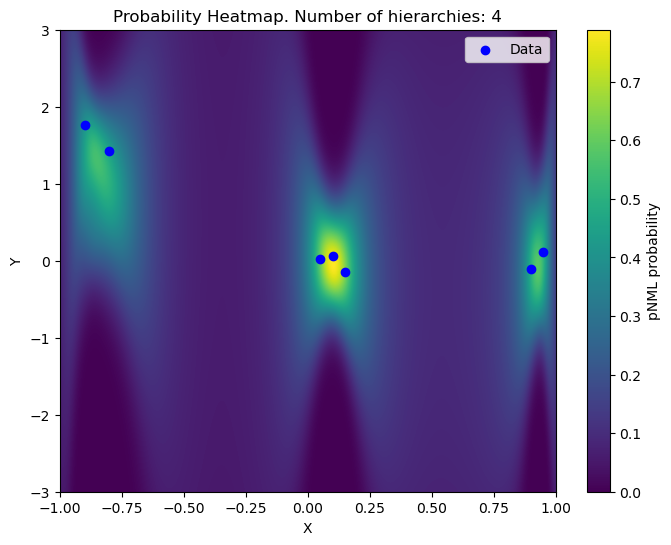

(0, 1, 2, 3, 4)
(0, 1, 2, 3, 5)
(0, 1, 2, 4, 5)
(0, 1, 3, 4, 5)
(0, 2, 3, 4, 5)
(1, 2, 3, 4, 5)


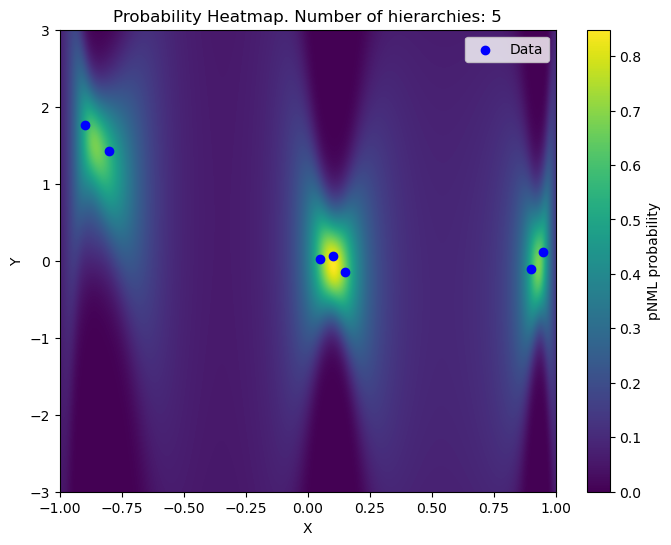

In [ ]:
U, s, _ = np.linalg.svd(X_poly.T @ X_poly, hermitian=True)
subspace_predictions = []

num_subspaces, hierarchies = num_features , 2
for hierarchies in range(1, num_features ):
    combs = list(itertools.combinations(range(num_subspaces), hierarchies))

    Z = np.zeros((len(combs), len(y_interval), len(x_interval)))
    for n, subspace in enumerate(combs):
        print(subspace)
        subspace = [subspace[0]] if len(subspace) == 1 else subspace

        y_pred_svd, x_inv = calc_subspace_prediction(
            X_pred_poly, X_poly, y, U, s, subspace
        )
        nf = get_pnml_normalization_factor(X_pred_poly, X_poly, x_inv=x_inv)

        for i, x in enumerate(x_interval):
            mu = y_pred_svd[i].squeeze()
            var = 0.1 * nfs[i].squeeze() ** 2
            predictions = calc_gaussian_probabilities(mu, var, y_interval)
            Z[n, :, i] = predictions

    Z_avg = np.mean(Z, axis=0)
    plt.figure(figsize=(8, 6))
    plt.scatter(x_training, y_training, color="blue", label="Data")
    plt.imshow(
        Z_avg,
        extent=[x_interval[0], x_interval[-1], y_interval[0], y_interval[-1]],
        origin="lower",
        aspect="auto",
        cmap="viridis",
    )
    plt.colorbar(label="pNML probability")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Probability Heatmap. Number of hierarchies: {hierarchies}")
    plt.legend()
    plt.show()